# MMPose预训练模型预测-Python API

同济子豪兄 2023-4-1

## 进入 mmpose 主目录

In [1]:
import os
os.chdir('mmpose')

## 导入工具包

In [2]:
import cv2
import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

import torch

import mmcv
from mmcv import imread
import mmengine
from mmengine.registry import init_default_scope

from mmpose.apis import inference_topdown
from mmpose.apis import init_model as init_pose_estimator
from mmpose.evaluation.functional import nms
from mmpose.registry import VISUALIZERS
from mmpose.structures import merge_data_samples

from mmdet.apis import inference_detector, init_detector

In [3]:
# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


## 载入待测图像

In [4]:
img_path = 'data/test/multi-person.jpeg'

In [5]:
# Image.open(img_path)

## 构建目标检测模型（任选一个运行）

In [6]:
# Faster R CNN
detector = init_detector(
    'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py',
    'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth',
    device=device
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth


In [7]:
# # RTMPose-Tiny
# # https://github.com/open-mmlab/mmpose/tree/dev-1.x/projects/rtmpose
# detector = init_detector(
#     'projects/rtmpose/rtmdet/person/rtmdet_m_640-8xb32_coco-person.py',
#     'https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_m_8xb32-100e_coco-obj365-person-235e8209.pth',
#     device=device
# )

## 构建人体姿态估计模型

In [8]:
pose_estimator = init_pose_estimator(
    'configs/body_2d_keypoint/topdown_heatmap/coco/td-hm_hrnet-w32_8xb64-210e_coco-256x192.py',
    'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth',
    device=device,
    cfg_options={'model': {'test_cfg': {'output_heatmaps': True}}}
)

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w32_coco_256x192-c78dce93_20200708.pth


## 预测-目标检测

In [9]:
init_default_scope(detector.cfg.get('default_scope', 'mmdet'))

04/05 09:51:46 - mmengine - WARNING - The current default scope "mmpose" is not "mmdet", `init_default_scope` will force set the currentdefault scope to "mmdet".


In [10]:
# 获取目标检测预测结果
detect_result = inference_detector(detector, img_path)

In [11]:
detect_result.keys()

['gt_instances', 'pred_instances', 'ignored_instances']

In [12]:
# 预测类别
detect_result.pred_instances.labels

tensor([ 0,  0,  0,  0,  0,  0,  0,  0,  0, 11,  0, 58,  0,  0, 58,  0,  0,  2,
         0,  0,  2,  0,  0,  0,  0, 24,  2, 58, 26, 26,  0,  0, 58, 26,  0,  0,
        27, 24,  0, 26, 26, 26, 26, 26, 58,  0, 26, 26, 26,  2, 32,  2, 58, 39,
         2,  0, 24, 58, 58, 32, 24, 26,  0,  0,  2, 37,  0, 39,  9, 74,  0,  2,
        58, 24,  0,  0, 26, 29], device='cuda:0')

In [13]:
# 置信度
detect_result.pred_instances.scores

tensor([0.9994, 0.9988, 0.9974, 0.9963, 0.9959, 0.9930, 0.9914, 0.9901, 0.9868,
        0.9824, 0.9631, 0.9271, 0.9079, 0.8950, 0.8793, 0.8582, 0.8248, 0.8189,
        0.7240, 0.7184, 0.7055, 0.6653, 0.6202, 0.6010, 0.6001, 0.5708, 0.5651,
        0.5059, 0.4549, 0.4085, 0.3941, 0.3905, 0.3535, 0.3200, 0.3103, 0.2593,
        0.2291, 0.2222, 0.2155, 0.1886, 0.1864, 0.1846, 0.1791, 0.1771, 0.1715,
        0.1672, 0.1395, 0.1391, 0.1390, 0.1371, 0.1348, 0.1249, 0.1204, 0.1155,
        0.1129, 0.1121, 0.1010, 0.1009, 0.0939, 0.0922, 0.0919, 0.0916, 0.0885,
        0.0822, 0.0806, 0.0724, 0.0697, 0.0686, 0.0675, 0.0630, 0.0627, 0.0624,
        0.0587, 0.0580, 0.0557, 0.0536, 0.0509, 0.0503], device='cuda:0')

In [14]:
# 框坐标：左上角X坐标、左上角Y坐标、右下角X坐标、右下角Y坐标
# detect_result.pred_instances.bboxes

## 置信度阈值过滤，获得最终目标检测预测结果

In [15]:
# 置信度阈值
CONF_THRES = 0.5

In [16]:
pred_instance = detect_result.pred_instances.cpu().numpy()
bboxes = np.concatenate((pred_instance.bboxes, pred_instance.scores[:, None]), axis=1)
bboxes = bboxes[np.logical_and(pred_instance.labels == 0, pred_instance.scores > CONF_THRES)]
bboxes = bboxes[nms(bboxes, 0.3)][:, :4]

In [17]:
bboxes

array([[1705.6346  ,   96.27826 , 2114.5266  , 1301.1758  ],
       [1267.5778  ,   94.687965, 1701.0544  , 1316.3174  ],
       [ 720.3818  ,  172.25711 , 1152.6832  , 1267.835   ],
       [   7.265906,  238.25822 ,  171.00204 , 1140.8152  ],
       [1063.1827  ,  219.22768 , 1348.9985  , 1244.7667  ],
       [ 436.23984 ,  428.59134 ,  586.0956  ,  911.8946  ],
       [ 110.004326,  212.14702 ,  324.64917 , 1122.9872  ],
       [2079.3276  ,  478.235   , 2224.4104  ,  925.21655 ],
       [ 543.71216 ,  406.48138 ,  650.84064 ,  919.47424 ],
       [2363.2961  ,  501.86667 , 2455.2178  ,  857.2742  ],
       [2308.2     ,  561.4533  , 2372.7483  ,  715.7694  ],
       [1990.6042  ,  485.10464 , 2105.6313  ,  923.4552  ],
       [2255.5464  ,  568.4467  , 2326.8767  ,  702.4356  ],
       [ 830.38214 ,  297.20853 ,  897.0397  ,  349.59393 ],
       [ 704.9923  ,  419.55325 ,  808.7067  ,  989.61865 ],
       [1646.673   ,  484.3826  , 1787.3309  ,  936.49426 ],
       [2437.2651  ,  59

## 预测-关键点

In [18]:
# 获取每个 bbox 的关键点预测结果
pose_results = inference_topdown(pose_estimator, img_path, bboxes)

04/05 09:51:46 - mmengine - WARNING - The current default scope "mmdet" is not "mmpose", `init_default_scope` will force set the currentdefault scope to "mmpose".


In [19]:
len(pose_results)

18

In [20]:
# 把多个bbox的pose结果打包到一起
data_samples = merge_data_samples(pose_results)

In [21]:
data_samples.keys()

['gt_instances', '_pred_heatmaps', 'pred_instances', 'pred_fields']

## 预测结果-关键点坐标

In [22]:
# 每个人 17个关键点 坐标
data_samples.pred_instances.keypoints.shape

(18, 17, 2)

In [23]:
# 索引为 0 的人，每个关键点的坐标
data_samples.pred_instances.keypoints[0,:,:]

array([[1915.96385447,  186.88096142],
       [1927.7304306 ,  175.11438465],
       [1892.43070221,  175.11438465],
       [1963.030159  ,  198.64753819],
       [1857.13097382,  186.88096142],
       [2010.09646352,  316.31330585],
       [1810.06466929,  328.07988262],
       [2092.46249644,  492.81195736],
       [1786.53151703,  445.74565029],
       [1986.56331126,  410.44591999],
       [1762.99836477,  504.57853413],
       [1963.030159  ,  657.5440321 ],
       [1821.83124542,  645.77745533],
       [1939.49700673,  939.9418745 ],
       [1821.83124542,  904.6421442 ],
       [1927.7304306 , 1116.44052601],
       [1857.13097382, 1187.03998661]])

## 预测结果-关键点热力图

In [24]:
# 每一类关键点的预测热力图
data_samples.pred_fields.heatmaps.shape

(17, 1418, 2520)

In [25]:
idx_point = 13
heatmap = data_samples.pred_fields.heatmaps[idx_point,:,:]

In [26]:
heatmap.shape

(1418, 2520)

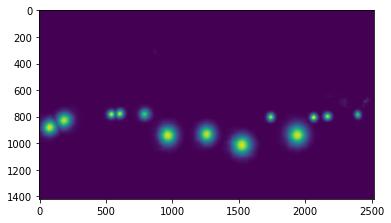

In [27]:
# 索引为 idx 的关键点，在全图上的预测热力图
plt.imshow(heatmap)
plt.show()

## MMPose官方可视化工具`visualizer`

In [28]:
# 半径
pose_estimator.cfg.visualizer.radius = 10
# 线宽
pose_estimator.cfg.visualizer.line_width = 8
visualizer = VISUALIZERS.build(pose_estimator.cfg.visualizer)
# 元数据
visualizer.set_dataset_meta(pose_estimator.dataset_meta)

04/05 09:51:58 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


In [29]:
# 元数据
# pose_estimator.dataset_meta

## 展示可视化效果

In [30]:
img = mmcv.imread(img_path)
img = mmcv.imconvert(img, 'bgr', 'rgb')

img_output = visualizer.add_datasample(
            'result',
            img,
            data_sample=data_samples,
            draw_gt=False,
            draw_heatmap=True,
            draw_bbox=True,
            show_kpt_idx=True,
            show=False,
            wait_time=0,
            out_file='outputs/B2.jpg'
)

In [31]:
img_output.shape

(2836, 2520, 3)

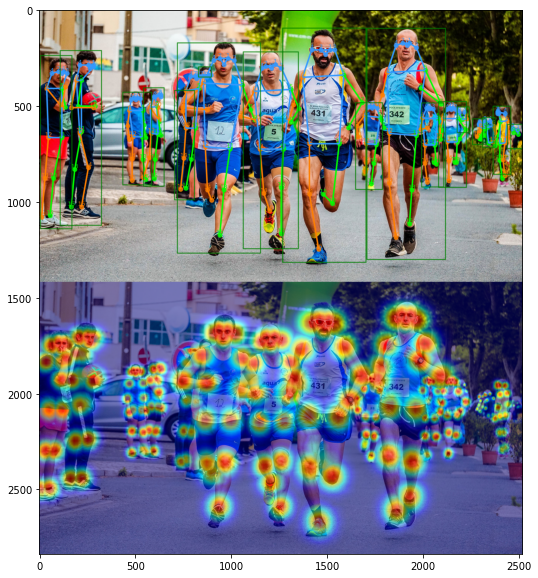

In [32]:
plt.figure(figsize=(10,10))
plt.imshow(img_output)
plt.show()